In [1]:
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [55]:
def load_data(file_path):
    with open(file_path, 'r', errors='ignore') as file:
        return [line.strip() for line in file]
    
def load_data(file_path):
    with open(file_path, 'r', errors='ignore') as file:
        return [line.strip() for line in file]
    
def preprocess_data(train_data, vocabulary, min_df=2):
    # Initialize stopwords and lemmatizer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Preprocess vocabulary
    preprocessed_vocab = {}
    for i, word in enumerate(vocabulary):
        if word.lower() not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word.lower())
            preprocessed_vocab[i] = lemmatized_word

    rows, cols, values = [], [], []
    doc_count = np.zeros(len(preprocessed_vocab), dtype=int)
    
    for line in train_data:
        doc_id, word_id, count = map(int, line.split())
        if word_id - 1 in preprocessed_vocab:
            doc_count[word_id - 1] += 1

    # Filter out words that appear in fewer than `min_df` documents
    valid_words = {i: preprocessed_vocab[i] for i, count in enumerate(doc_count) if count >= min_df and i in preprocessed_vocab}
    filtered_vocab = list(valid_words.values())
    word_index_map = {old_idx: new_idx for new_idx, (old_idx, _) in enumerate(valid_words.items())}

    for line in train_data:
        doc_id, word_id, count = map(int, line.split())
        if word_id - 1 in valid_words:
            new_word_id = word_index_map[word_id - 1]
            rows.append(doc_id - 1)  # Convert to zero-indexed
            cols.append(new_word_id)  # Use new word id
            values.append(count)
    
    X = csr_matrix((values, (rows, cols)), shape=(len(set(rows)), len(filtered_vocab)))
    
    return X, filtered_vocab

In [3]:
data_dir = '../data/20newsgroup'
# Load training data
train_data = load_data(os.path.join(data_dir, 'train.data'))
train_labels = load_data(os.path.join(data_dir, 'train.label'))
vocabulary = load_data(os.path.join(data_dir, 'vocabulary.txt'))

In [4]:
X_train, filtered_vocab = preprocess_data(train_data, vocabulary)
# Train LDA model with custom logging
n_topics = 20  # Number of topics
max_iter = 20  # Maximum number of iterations
log_every = 1  # Log every 'log_every' iterations

lda = LatentDirichletAllocation(n_components=n_topics, random_state=0, learning_decay=0.7, max_iter=max_iter)
lda.fit(X_train)

LatentDirichletAllocation(max_iter=20, n_components=20, random_state=0)

In [14]:
print(lda.score(X_train))
print(lda.perplexity(X_train))

-13464528.611916121
5070.362753814555


In [44]:
# Predict topics
probs = lda.transform(X_train)
pred_labels = probs.argmax(axis=1) + 1
true_labels = np.array(list(map(int, train_labels)))

In [48]:
pred_labels.min()

1

In [41]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
# Use the Hungarian algorithm to find the best assignment
row_ind, col_ind = linear_sum_assignment(conf_matrix.max() - conf_matrix)
optimal_labels = np.zeros_like(pred_labels)
for i, j in zip(row_ind, col_ind):
    optimal_labels[pred_labels == j] = i
    
# Evaluate clustering performance
ari = adjusted_rand_score(true_labels, optimal_labels)
nmi = normalized_mutual_info_score(true_labels, optimal_labels)


print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

#Use train.map to map the number to the real topic
train_map = load_data(os.path.join(data_dir, 'train.map'))
for line in train_map:
    topic, idx = line.split()
    idx = int(idx)

# Print the top words per topic

terms = np.array(filtered_vocab)
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print(" ".join(terms[i] for i in topic.argsort()[:-11:-1]))

Adjusted Rand Index: 0.2217510643475847
Normalized Mutual Information: 0.3799890278919364
Topic #1:
car com edu writes drive article car would price hp
Topic #2:
game team game hockey play season win year ca go
Topic #3:
edu year writes good one better run article would like
Topic #4:
file edu available ftp use file mail also com image
Topic #5:
window drive card scsi mb do one use would system
Topic #6:
space launch satellite program information new militia research shuttle technology
Topic #7:
one like would know time get said com u back
Topic #8:
gun db gun law police crime weapon com state firearm
Topic #9:
com writes edu article would nasa gov apr one space
Topic #10:
edu would writes article know one like could ca anyone
Topic #11:
key encryption chip government key clipper security use privacy public
Topic #12:
people turkish armenian president mr armenian said government would going
Topic #13:
window new one com like sale phone radio used would
Topic #14:
output file entry prog

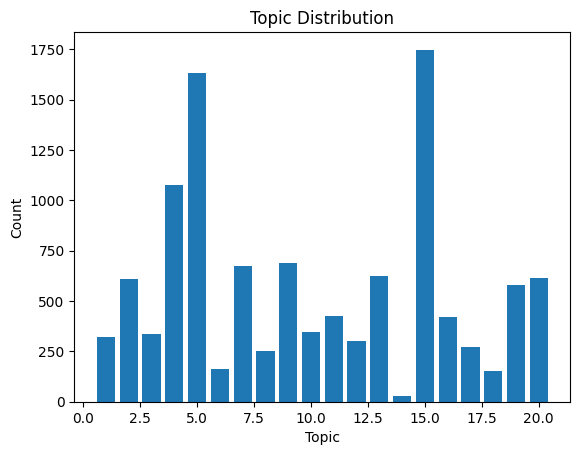

In [49]:
import matplotlib.pyplot as plt

plt.bar(range(1, n_topics+1), np.bincount(pred_labels-1))
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

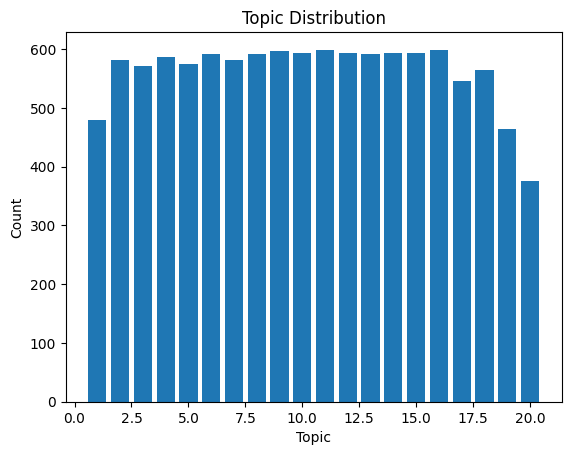

In [50]:
import matplotlib.pyplot as plt

plt.bar(range(1, n_topics+1), np.bincount(true_labels-1))
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

In [51]:
#Load test data
test_data = load_data(os.path.join(data_dir, 'test.data'))
test_labels = load_data(os.path.join(data_dir, 'test.label'))

In [58]:
def preprocess_test_data(train_data, vocabulary, min_df=2):
    # Initialize stopwords and lemmatizer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Preprocess vocabulary
    preprocessed_vocab = {}
    for i, word in enumerate(vocabulary):
        if word.lower() not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word.lower())
            preprocessed_vocab[i] = lemmatized_word

    rows, cols, values = [], [], []
    doc_count = np.zeros(len(vocabulary), dtype=int)
    
    for line in train_data:
        doc_id, word_id, count = map(int, line.split())
        if word_id - 1 in preprocessed_vocab:
            doc_count[word_id - 1] += 1

    # Filter out words that appear in fewer than `min_df` documents
    valid_words = set(i for i, count in enumerate(doc_count) if count >= min_df)
    filtered_vocab = [preprocessed_vocab[i] for i in valid_words if i in preprocessed_vocab]
    
    for line in train_data:
        doc_id, word_id, count = map(int, line.split())
        if word_id - 1 in valid_words and word_id - 1 in preprocessed_vocab:
            rows.append(doc_id - 1)  # Convert to zero-indexed
            cols.append(word_id - 1)  # Convert to zero-indexed
            values.append(count)
    
    X = csr_matrix((values, (rows, cols)), shape=(len(set(rows)), len(vocabulary)))
    
    return X, filtered_vocab

In [60]:
#Evaluate on the test data
X_test, _ = preprocess_test_data(test_data, filtered_vocab)
probs = lda.transform(X_test)
pred_labels = probs.argmax(axis=1) + 1
true_labels = np.array(list(map(int, test_labels)))

In [61]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
# Use the Hungarian algorithm to find the best assignment
row_ind, col_ind = linear_sum_assignment(conf_matrix.max() - conf_matrix)
optimal_labels = np.zeros_like(pred_labels)
for i, j in zip(row_ind, col_ind):
    optimal_labels[pred_labels == j] = i
    
# Evaluate clustering performance
ari = adjusted_rand_score(true_labels, optimal_labels)
nmi = normalized_mutual_info_score(true_labels, optimal_labels)

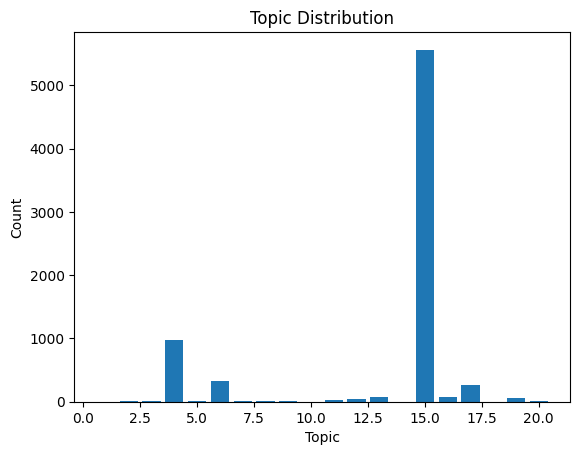

In [62]:
import matplotlib.pyplot as plt

plt.bar(range(1, n_topics+1), np.bincount(pred_labels-1))
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()